# Generate some reference images & gradients.

In [1]:
#@title: Imports
# Train a whole image, see how that progresses for reference.
# Maybe capture first training step as something... ?
import math
import os
import gc
import time
from pathlib import Path
import mediapy

import numpy as np
import torch
from gsplat import project_gaussians
from gsplat import rasterize_gaussians
from gsplat import spherical_harmonics

import matplotlib.pyplot as plt

from PIL import Image

from safetensors.torch import save_file
from safetensors import safe_open

import dataclasses

In [2]:
g_device = torch.device("cuda:0")
DEFAULT_TILE_SIZE = 16


In [3]:
# Helper functions
@dataclasses.dataclass(frozen=True)
class Camera:
    viewmat: torch.Tensor
    focal: float
    w: int
    h: int
    background: torch.Tensor


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms
    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor.to("cuda:0")

def fov_to_focal(fov: float, img_size: int) -> float: 
    return 0.5 * float(img_size) / math.tan(0.5 * fov)

def basic_camera(w: int, h: int) -> Camera:
    background = torch.zeros(3, device=g_device)
    fov_x = math.pi / 2.0
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=g_device,
    )
    focal = fov_to_focal(fov_x, w)
    return Camera(viewmat=viewmat, w=w, h=h, focal=focal, background=background)

In [4]:
crab_img = image_path_to_tensor("./crab.png")

def execute_test(means, log_scales, quats, coeffs, opacities, name: str):
    means.requires_grad = True
    log_scales.requires_grad = True
    quats.requires_grad = True
    coeffs.requires_grad = True
    opacities.requires_grad = True

    H, W, _ = crab_img.shape
    cam = basic_camera(W, H)

    xys, depths, radii, conics, _comp, num_tiles_hit, _cov3d = project_gaussians(
        means,
        log_scales.exp(),
        1,
        quats,
        cam.viewmat,
        cam.focal,
        cam.focal,
        cam.w / 2,
        cam.h / 2,
        cam.h,
        cam.w,
        DEFAULT_TILE_SIZE,
        0.01
    )
    
    viewdirs = means - cam.viewmat[:3, 3]  # (N, 3)
    colors = spherical_harmonics(0, viewdirs, coeffs) + 0.5
    out_img = rasterize_gaussians(
        xys,
        depths,
        radii,
        conics,
        num_tiles_hit,
        colors,
        torch.sigmoid(opacities[:, None]),
        H,
        W,
        DEFAULT_TILE_SIZE,
        cam.background,
    )[..., :3]
    out_img.retain_grad()
    conics.retain_grad()
    xys.retain_grad()
    mediapy.show_image((out_img.detach().cpu().numpy() * 255.0).astype(np.uint8), width=W*4, height=H*4)

    loss = ((out_img - crab_img) ** 2).mean()
    loss.backward()
    tensors = {
        "means": means,
        "scales": log_scales,
        "coeffs": coeffs,
        "quats": quats,
        "opacities": opacities,
        "depths": depths,
        "xys": xys,
        "radii": radii,
        "conics": conics,
        "out_img": out_img,

        "v_xy": xys.grad,
        "v_conics": conics.grad,
        "v_means": means.grad,
        "v_scales": log_scales.grad,
        "v_coeffs": coeffs.grad,
        "v_quats": quats.grad,
        "v_opacities": opacities.grad,
        "v_out_img": out_img.grad,
    }
    save_file(tensors, f"./{name}.safetensors")

c:\Users\A-Bru\anaconda3\envs\nerfstudio\lib\site-packages\torch\utils\cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


""

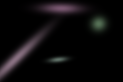

In [5]:

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(14)
    num_points = 4
    means = 10.5 * (torch.rand(num_points, 3, device=g_device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=g_device) * 2.5).log()
    coeffs = torch.rand(num_points, 1, 3, device=g_device)
    u = torch.rand(num_points, 1, device=g_device)
    v = torch.rand(num_points, 1, device=g_device)
    w = torch.rand(num_points, 1, device=g_device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=g_device) * 0.5 + 0.5
    execute_test(means, log_scales, quats, coeffs, opacities, "tiny_case")

test_case()

""

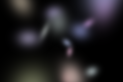

In [6]:

# Simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(3)
    num_points = 16
    means = 10.0 * (torch.rand(num_points, 3, device=g_device) - 0.5)
    log_scales = torch.rand(num_points, 3, device=g_device).log() * 0.5
    coeffs = torch.rand(num_points, 1, 3, device=g_device)
    u = torch.rand(num_points, 1, device=g_device)
    v = torch.rand(num_points, 1, device=g_device)
    w = torch.rand(num_points, 1, device=g_device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=g_device) * 0.5 + 0.5
    execute_test(means, log_scales, quats, coeffs, opacities, "basic_case")

test_case()


""

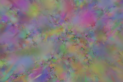

In [7]:

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(4)
    num_points = 76873
    means = 2000.0 * (torch.rand(num_points, 3, device=g_device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=g_device) * 15.0 + 0.05).log()
    coeffs = torch.rand(num_points, 1, 3, device=g_device) * 2.0 - 1.0
    u = torch.rand(num_points, 1, device=g_device)
    v = torch.rand(num_points, 1, device=g_device)
    w = torch.rand(num_points, 1, device=g_device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=g_device)
    execute_test(means, log_scales, quats, coeffs, opacities, "mix_case")

test_case()

In [8]:
def generate_bench_data():
    torch.manual_seed(4)

    num_points = 2 ** 21  #  Maxmimum number of splats to bench.
    means = 10000.0 * (torch.rand(num_points, 3, device=g_device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=g_device) * 15.0 + 0.05).log()
    coeffs = torch.rand(num_points, 1, 3, device=g_device) * 2.0 - 1.0

    u = torch.rand(num_points, 1, device=g_device)
    v = torch.rand(num_points, 1, device=g_device)
    w = torch.rand(num_points, 1, device=g_device)

    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=g_device)

    means.requires_grad = True
    log_scales.requires_grad = True
    quats.requires_grad = True
    coeffs.requires_grad = True
    opacities.requires_grad = True

    tensors = {
        "means": means,
        "scales": log_scales,
        "coeffs": coeffs,
        "quats": quats,
        "opacities": opacities,
    }
    save_file(tensors, f"./bench_data.safetensors")

    w, h = (512, 512)
    cam = basic_camera(w, h)

    xys, depths, radii, conics, _comp, num_tiles_hit, _cov3d = project_gaussians(
        means,
        log_scales.exp(),
        1,
        quats,
        cam.viewmat,
        cam.focal,
        cam.focal,
        cam.w / 2,
        cam.h / 2,
        cam.h,
        cam.w,
        DEFAULT_TILE_SIZE,
        0.01
    )
    viewdirs = means - cam.viewmat[:3, 3]  # (N, 3)
    colors = spherical_harmonics(0, viewdirs, coeffs) + 0.5
    out_img = rasterize_gaussians(
        xys,
        depths,
        radii,
        conics,
        num_tiles_hit,
        colors,
        torch.sigmoid(opacities[:, None]),
        cam.w,
        cam.h,
        DEFAULT_TILE_SIZE,
        cam.background,
    )[..., :3]
    plt.imshow(out_img.detach().cpu())

def load_bench_tensors(point_frac: float, mean_mult: float, grad: bool):
    with safe_open("./bench_data.safetensors", framework="pt", device="cpu") as f:
        means: torch.Tensor = f.get_tensor("means")
        num_points = int(means.shape[0] * point_frac)
        means = means[0:num_points, ...] * mean_mult
        scales: torch.Tensor = f.get_tensor("scales")[0:num_points, ...]
        coeffs: torch.Tensor = f.get_tensor("coeffs")[0:num_points, ...]
        quats: torch.Tensor = f.get_tensor("quats")[0:num_points, ...]
        opacities: torch.Tensor = f.get_tensor("opacities")[0:num_points, ...]

    means = means.to(device=g_device).detach()
    scales = scales.to(device=g_device).detach()
    coeffs = coeffs.to(device=g_device).detach()
    quats = quats.to(device=g_device).detach()
    opacities = opacities.to(device=g_device).detach()

    # Not sure if this really fixes it but we can't save benchmarks if the file remains open
    # accidentally.
    del f
    gc.collect()
    means.requires_grad = grad
    scales.requires_grad = grad
    coeffs.requires_grad = grad
    quats.requires_grad = grad
    opacities.requires_grad = grad

    return means, scales, coeffs, quats, opacities

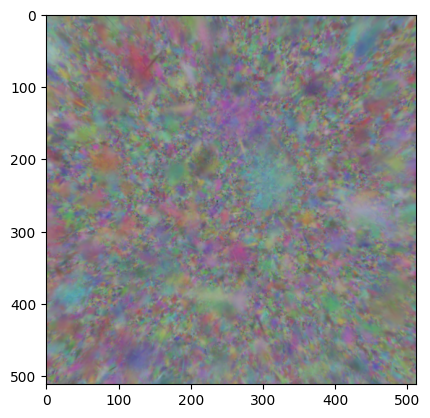

In [9]:
generate_bench_data()

In [29]:

BENCH_DENSITIES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
DENSE_MULT = 0.25

TARGET_SAMPLE_COUNT = 40
INTERNAL_ITERS = 2

def bench_general(point_frac: float, mean_mult: float, w: int, h: int, calc_grads: bool):
    # Generate camera
    cam = basic_camera(w, h)
    means, log_scales, coeffs, quats, opacities = load_bench_tensors(point_frac, mean_mult, calc_grads)

    def measure_iter():
        def internal_iter():
            xys, depths, radii, conics, _comp, num_tiles_hit, _cov3d = project_gaussians(
                means,
                log_scales.exp(),
                1,
                quats,
                cam.viewmat,
                cam.focal,
                cam.focal,
                cam.w / 2,
                cam.h / 2,
                cam.h,
                cam.w,
                DEFAULT_TILE_SIZE,
                0.01
            )
            viewdirs = means - cam.viewmat[:3, 3]  # (N, 3)
            colors = spherical_harmonics(0, viewdirs, coeffs) + 0.5
            out_img = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                colors,
                torch.sigmoid(opacities[:, None]),
                cam.h,
                cam.w,
                DEFAULT_TILE_SIZE,
                cam.background,
            )

            if calc_grads:
                xys.retain_grad()
                loss = out_img.mean()
                loss.backward()

        start_time = time.time()
        for _ in range(INTERNAL_ITERS):
            internal_iter()
        torch.cuda.synchronize(g_device)
        bench_time = time.time() - start_time
        return bench_time
    
    ret = np.median([measure_iter() for _ in range(TARGET_SAMPLE_COUNT)])
    print(f"bench_time: {ret}")
    return ret

In [30]:
gc.collect()

bench_times = {}

for grad in [False, True]:
    name = "fwd" if not grad else "bwd"
    print(f"{name} base")
    bench_times[f"{name}_base"] = [bench_general(dens, 1.0, 512, 512, grad) for dens in BENCH_DENSITIES]
    print(f"{name} dense")
    bench_times[f"{name}_dense"] = [bench_general(dens, DENSE_MULT, 512, 512, grad) for dens in BENCH_DENSITIES]
    print(f"{name} hd")
    bench_times[f"{name}_hd"] = [bench_general(dens, 1.0, 1024, 1024, grad) for dens in BENCH_DENSITIES]

fwd base
bench_time: 0.002000570297241211
bench_time: 0.0030001401901245117
bench_time: 0.0040024518966674805
bench_time: 0.004998326301574707
bench_time: 0.006000638008117676
bench_time: 0.007073402404785156
bench_time: 0.008099079132080078
bench_time: 0.009114623069763184
bench_time: 0.011008262634277344
bench_time: 0.01209723949432373
fwd dense
bench_time: 0.0020530223846435547
bench_time: 0.0039986371994018555
bench_time: 0.004122376441955566
bench_time: 0.005195975303649902
bench_time: 0.007082700729370117
bench_time: 0.009002327919006348
bench_time: 0.010124802589416504
bench_time: 0.013407707214355469
bench_time: 0.015123486518859863
bench_time: 0.016002297401428223
fwd hd
bench_time: 0.002001047134399414
bench_time: 0.003000020980834961
bench_time: 0.00500035285949707
bench_time: 0.007000446319580078
bench_time: 0.008000016212463379
bench_time: 0.00900423526763916
bench_time: 0.010998129844665527
bench_time: 0.012119650840759277
bench_time: 0.014110684394836426
bench_time: 0.02

In [24]:
bench_times

{'fwd_base': [0.0020002126693725586,
  0.0030995607376098633,
  0.005753755569458008,
  0.008098721504211426,
  0.009123921394348145],
 'fwd_dense': [0.0030034780502319336,
  0.005998849868774414,
  0.00807332992553711,
  0.010126471519470215,
  0.013033628463745117],
 'fwd_hd': [0.0030001401901245117,
  0.007100701332092285,
  0.01203775405883789,
  0.01704871654510498,
  0.021713972091674805],
 'bwd_base': [0.0050917863845825195,
  0.016085386276245117,
  0.03093552589416504,
  0.026316523551940918,
  0.03412890434265137],
 'bwd_dense': [0.0111161470413208,
  0.01725482940673828,
  0.022333502769470215,
  0.02416515350341797,
  0.028287172317504883],
 'bwd_hd': [0.008103728294372559,
  0.017339229583740234,
  0.02429354190826416,
  0.03365933895111084,
  0.04703104496002197]}

In [33]:
rust_times = {
    "bwd_base": [7.005, 8.113, 11.09, 13.34, 18.69, 19.36, 25.05, 24.66, 32.05, 32.94],
    "bwd_dense": [13.41, 16.28, 24.08, 19.33, 30.15, 33.93, 38.54, 40.89, 41.26, 48.35],
    "bwd_hd": [20.38, 26.85, 27.01, 32.42, 36.44, 41.26, 46.62, 52.92, 59.64, 67.08],
    "fwd_base": [1.574, 2.445, 3.685, 4.931, 6.111, 6.986, 8.367, 9.496, 10.73, 12.98],
    "fwd_dense": [3.112, 4.135, 4.55, 5.357, 6.7, 7.463, 9.149, 10.45, 10.93, 12.36],
    "fwd_hd": [2.934, 3.735, 4.962, 6.584, 8.515, 10.12, 11.73, 14.64, 16.61, 16.31]
}

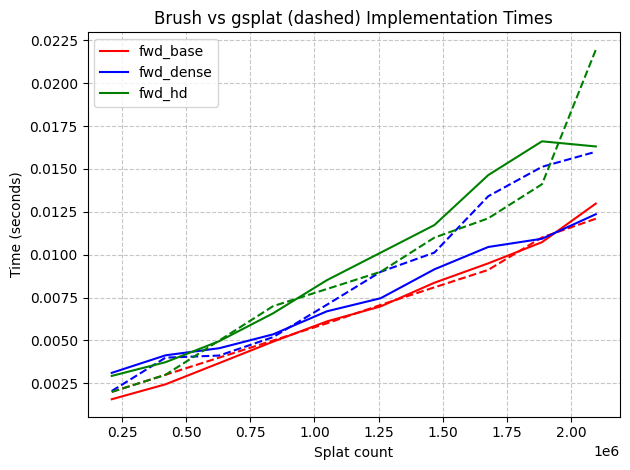

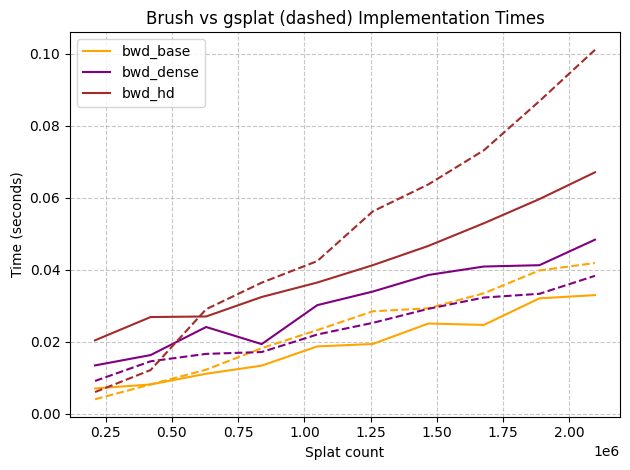

In [35]:
for bench_type in ['fwd', 'bwd']:
    # Colors for each type of line
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

    # Plot lines
    for key, color in zip(bench_times.keys(), colors):
        if not bench_type in key:
            continue
        rust_values = rust_times[key]
        python_values = bench_times[key]

        counts = np.array(BENCH_DENSITIES) * (2 ** 21)

        plt.plot(counts, np.array(rust_values) / 1000.0, label=key, color=color, linestyle='-') 
        plt.plot(counts, python_values, color=color, linestyle='--')

    # Customize the plot
    plt.xlabel('Splat count')
    plt.ylabel('Time (seconds)')
    plt.title('Brush vs gsplat (dashed) Implementation Times')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    legend1 = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().add_artist(legend1)
    plt.legend(loc='upper left') 

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()